# Roberta score calculateing among databases

2020/12/01

Student: Xuanyu Su                                                                 
Supervisor: Isar Nejadgholi

In this version, we modified the display of the distance comparison graphs, differences shown after changes were made.

______________________________________________________________________________________

in this module we are trying to explore the Roberta score among three data sets(ac, toxicity and gab) and to observe the distribution of these three datasets. 

Roberta score is extracted from the final linear layer of Roberta model, the original data is [x, -y]. The final score is sum(x-y). In this case, the score represents the pos/neg trendency and model discrimination range.

In [1]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup

In [2]:
# Initialize tokenizer.
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [3]:
source_folder = 'Data'
destination_folder = 'Model'

In [4]:
import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

# Set random seed and set device to GPU.
torch.manual_seed(17)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

cuda:0


In [5]:
# Model parameter
MAX_SEQ_LEN = 128
BATCH_SIZE = 8
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)
fields = [('comment', text_field),('toxicity', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='Train_comment_toxity.csv', validation='Val_comment_toxity.csv',
                                           test='Test_comment_toxity.csv', format='CSV', fields=fields, skip_header=True)


train_iter_toxity = BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter_toxity = BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter_toxity = Iterator(train, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [147]:
# Model parameter
MAX_SEQ_LEN = 128
BATCH_SIZE = 8
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)
fields = [('comment', text_field),('toxicity', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='Train_EA.csv', validation='Val_EA.csv',
                                           test='Test_EA.csv', format='CSV', fields=fields, skip_header=True)


train_iter_EA = BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter_EA = BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter_EA = Iterator(train, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [6]:
def embedding_on_GAB(test_file, text_name,label_name):
    # Model parameter
    MAX_SEQ_LEN = 128
    # Set tokenizer hyperparameters.
    BATCH_SIZE = 8
    PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
    UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)


    # Define columns to read.
    label_field = Field(sequential=False, use_vocab=False, batch_first=True)
    text_field = Field(use_vocab=False, 
                       tokenize=tokenizer.encode, 
                       include_lengths=False, 
                       batch_first=True,
                       fix_length=MAX_SEQ_LEN, 
                       pad_token=PAD_INDEX, 
                       unk_token=UNK_INDEX)

    fields = [(text_name, text_field),(label_name, label_field)]


    # TabularDataset

    train, valid, test = TabularDataset.splits(path=source_folder,train=test_file, validation=test_file,
                                               test=test_file, format='CSV', fields=fields, skip_header=True)


    train_iter = BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.Text),
                                device=device, train=True, sort=True, sort_within_batch=True)
    valid_iter = BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.Text),
                                device=device, train=True, sort=True, sort_within_batch=True)
    test_iter = Iterator(test, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)
 
    return train_iter, valid_iter, test_iter

In [7]:
Text_field = 'Text'
label_field = 'Hate'
file_field = "final_GAB.csv"
train_iter_GAB, valid_iter_GAB, GAB_embedding = embedding_on_GAB(file_field,Text_field ,label_field)

In [10]:
# Functions for saving and loading model parameters and metrics.
def save_checkpoint(path, model, valid_loss):
    torch.save({'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}, path)

    
def load_checkpoint(path, model):    
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):   
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, path)


def load_metrics(path):    
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [156]:
# Model with extra layers on top of RoBERTa
class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ROBERTAClassifier, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, 2)
        
    def forward(self, input_ids, attention_mask):
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x1 = self.d1(x)
        x2 = self.l1(x1)
        x3 = self.bn1(x2)
        x4 = torch.nn.Tanh()(x3)
        x5 = self.d2(x4)
        x6 = self.l2(x5)
        
        return x6

In [11]:
output_path = 'Model_roberta'
model = ROBERTAClassifier()
model = model.to(device)

load_checkpoint(output_path + '/model.pkl', model)

0.08750647318014222

In [157]:
output_path = 'Model_roberta_EA'
model = ROBERTAClassifier()
model = model.to(device)

load_checkpoint(output_path + '/model.pkl', model)

0.30514883347600696

In [158]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
# Evaluation Function
import seaborn as sns
def generate(model, test_loader):
    y_pred = []
    y_prob = []
    model.eval()
    with torch.no_grad():
        for (source, target), _ in tqdm(test_loader):
                mask = (source != PAD_INDEX).type(torch.uint8)
                output = model(source, attention_mask=mask)
                y_prob.extend(output.tolist())
    return y_prob

In [159]:
y_prob_GAb = generate(model, GAB_embedding)

100%|███████████████████████████████████████████████████████████████████████████| 3459/3459 [02:31<00:00, 22.89it/s]


In [160]:
y_prob_TOXITY = generate(model, test_iter_toxity)

100%|█████████████████████████████████████████████████████████████████████████| 11962/11962 [10:33<00:00, 18.88it/s]


In [161]:
y_prob_2400 = generate(model, test_iter_2400)

100%|█████████████████████████████████████████████████████████████████████████████| 290/290 [00:15<00:00, 18.55it/s]


In [162]:
y_prob_AC = generate(model, test_iter_AC)

100%|███████████████████████████████████████████████████████████████████████████| 8679/8679 [07:47<00:00, 18.57it/s]


In [163]:
y_prob_EA = generate(model, test_iter_EA)

100%|███████████████████████████████████████████████████████████████████████████| 2000/2000 [01:47<00:00, 18.52it/s]


In [165]:
y_prob_GAb_sum = [sum(i) for i in y_prob_GAb]
y_prob_TOXITY_sum = [sum(i) for i in y_prob_TOXITY]
y_prob_2400_sum = [sum(i) for i in y_prob_2400]
y_prob_AC_sum = [sum(i) for i in y_prob_AC]
y_prob_EA_sum = [sum(i) for i in y_prob_EA]

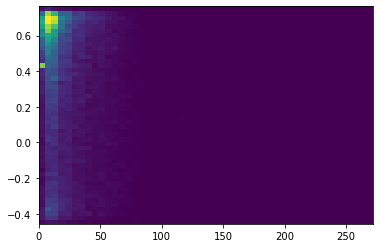

In [85]:
plt.hist2d(length_GAB,y_prob_GAb_sum,bins=50)
plt.show()

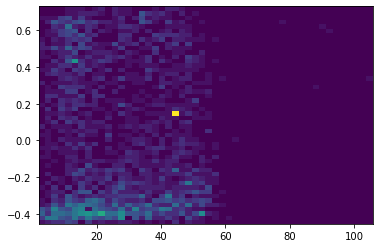

In [86]:
plt.hist2d(length_2400, y_prob_2400_sum,bins=50)
plt.show()

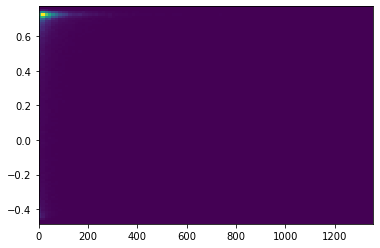

In [93]:
plt.hist2d(length_toxity, y_prob_TOXITY_sum,bins=100)
plt.show()

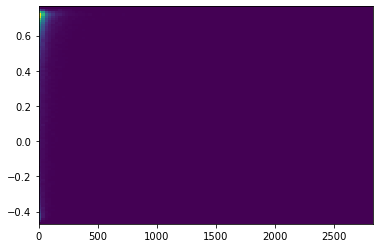

In [92]:
plt.hist2d(length_AC, y_prob_AC_sum,bins=100)
plt.show()

In [74]:
from scipy.stats.kde import gaussian_kde
length_GAB = np.array(length_GAB)
y_prob_GAb_sum = np.array(y_prob_GAb_sum)

def plot_histgram(x, y):
    k = gaussian_kde(np.vstack([x, y]))
    xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    fig = plt.figure(figsize=(7,8))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    # alpha=0.5 will make the plots semitransparent
    ax1.pcolormesh(xi, yi, zi.reshape(xi.shape), alpha=0.5)
    ax2.contourf(xi, yi, zi.reshape(xi.shape), alpha=0.5)
    ax1.set_xlim(x.min(), x.max())
    ax1.set_ylim(y.min(), y.max())
    ax2.set_xlim(x.min(), x.max())
    ax2.set_ylim(y.min(), y.max())
    plt.show()

In [ ]:
plot_histgram(length_GAB, y_prob_GAb_sum)

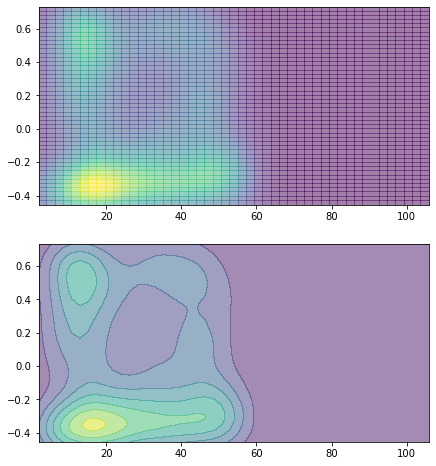

In [76]:
length_2400 = np.array(length_2400)
y_prob_2400_sum = np.array(y_prob_2400_sum)
plot_histgram(length_2400, y_prob_2400_sum)

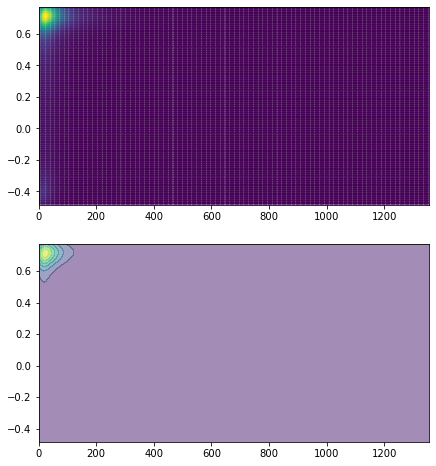

In [77]:
length_toxity = np.array(length_toxity)
y_prob_TOXITY_sum = np.array(y_prob_TOXITY_sum)
plot_histgram(length_toxity, y_prob_TOXITY_sum)

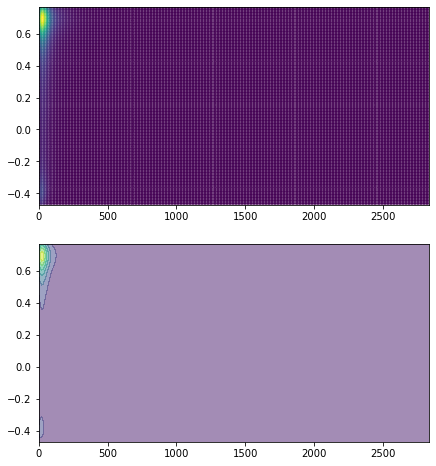

In [78]:
length_AC = np.array(length_AC)
y_prob_AC_sum = np.array(y_prob_AC_sum)
plot_histgram(length_AC, y_prob_AC_sum)

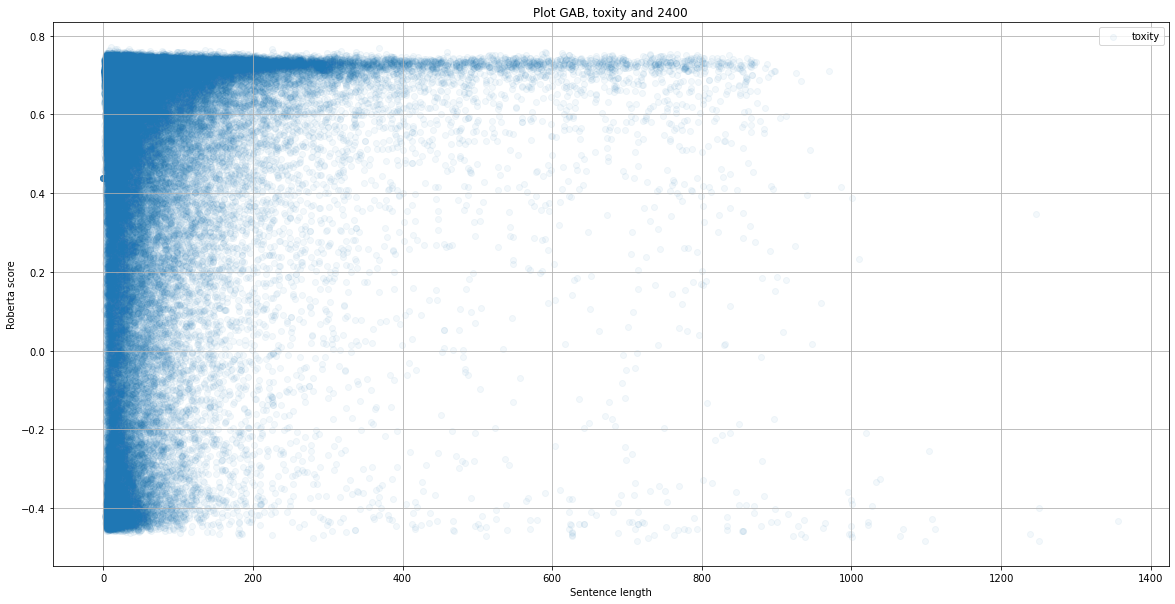

In [79]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
# plt.scatter(length_GAB, y_prob_GAb_sum, label = 'GAB',alpha=0.05)
plt.scatter(length_toxity, y_prob_TOXITY_sum,alpha=0.05, label = 'toxity')
# plt.scatter(length_2400, y_prob_2400_sum, label = '2400')
# plt.scatter(length_AC, y_prob_AC_sum, label = 'AC')
plt.title('Plot GAB, toxity and 2400')
plt.grid()
plt.ylabel('Roberta score')
plt.xlabel('Sentence length')
plt.legend()
plt.show()

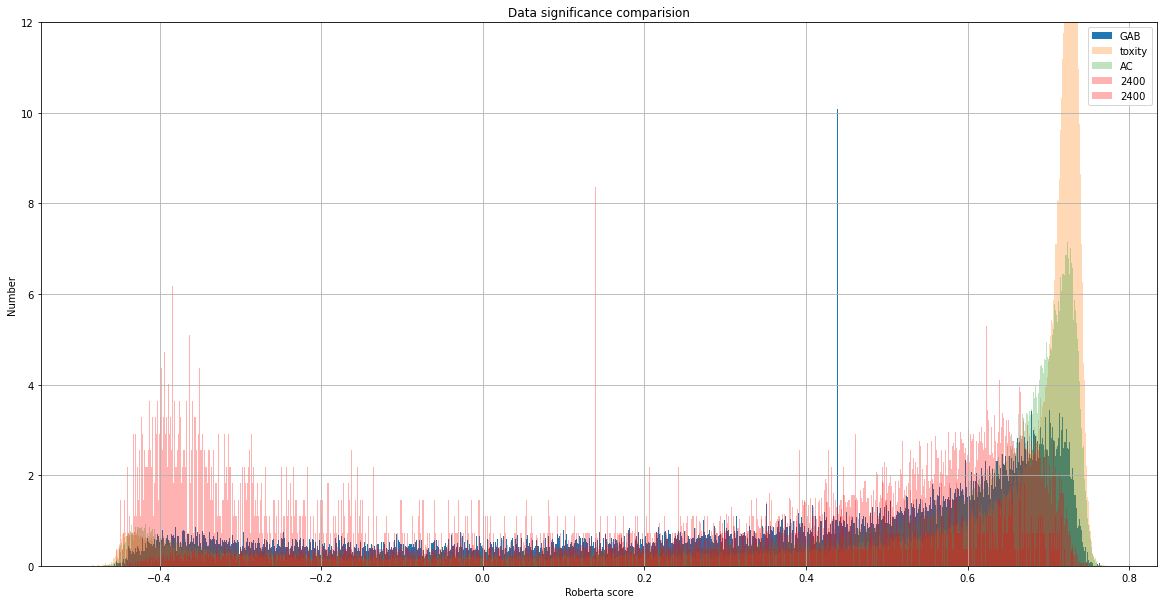

In [150]:
plt.figure(figsize=(20,10))
num_bins = 1000
n1, bins1, patches1 = plt.hist(y_prob_GAb_sum, density = True, label= 'GAB', bins=num_bins)
n2, bins2, patches2 = plt.hist(y_prob_TOXITY_sum,density = True, label = 'toxity', bins = num_bins,alpha = 0.3)
n3, bins3, patches3 = plt.hist(y_prob_AC_sum,label = 'AC', bins = num_bins,alpha = 0.3,density = True)
n4, bins4, patches4 = plt.hist(y_prob_2400_sum, label = '2400', bins = num_bins,color='r',density=True, alpha = 0.3)
n5, bins5, patches5 = plt.hist(y_prob_EA_sum, label = '2400', bins = num_bins,color='r',density=True, alpha = 0.3)


plt.title('Data significance comparision')
plt.grid()
plt.ylim(0,12)
plt.ylabel('Number')
plt.xlabel('Roberta score')
plt.legend()
plt.show()

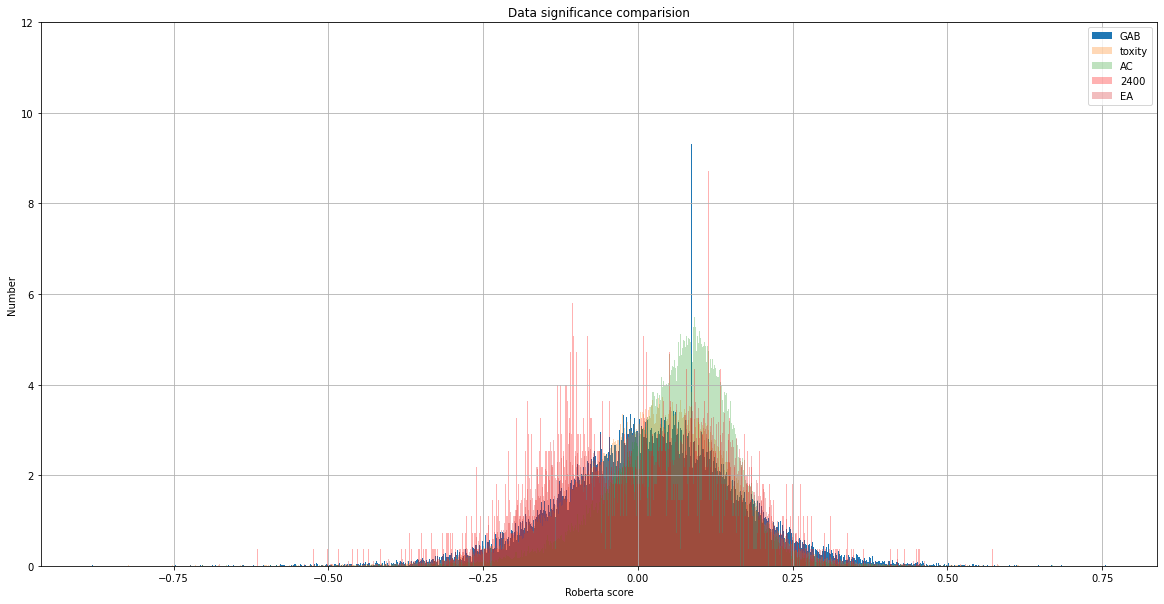

In [234]:
plt.figure(figsize=(20,10))
num_bins = 1000
n1, bins1, patches1 = plt.hist(y_prob_GAb_sum, density = True, label= 'GAB', bins=num_bins)
n2, bins2, patches2 = plt.hist(y_prob_TOXITY_sum,density = True, label = 'toxity', bins = num_bins,alpha = 0.3)
n3, bins3, patches3 = plt.hist(y_prob_AC_sum,label = 'AC', bins = num_bins,alpha = 0.3,density = True)
n4, bins4, patches4 = plt.hist(y_prob_2400_sum, label = '2400', bins = num_bins,color='r',density=True, alpha = 0.3)
n5, bins5, patches5 = plt.hist(y_prob_EA_sum, label = 'EA', bins = num_bins,density=True, alpha = 0.3)

plt.title('Data significance comparision')
plt.grid()
plt.ylim(0,12)
plt.ylabel('Number')
plt.xlabel('Roberta score')
plt.legend()
plt.show()

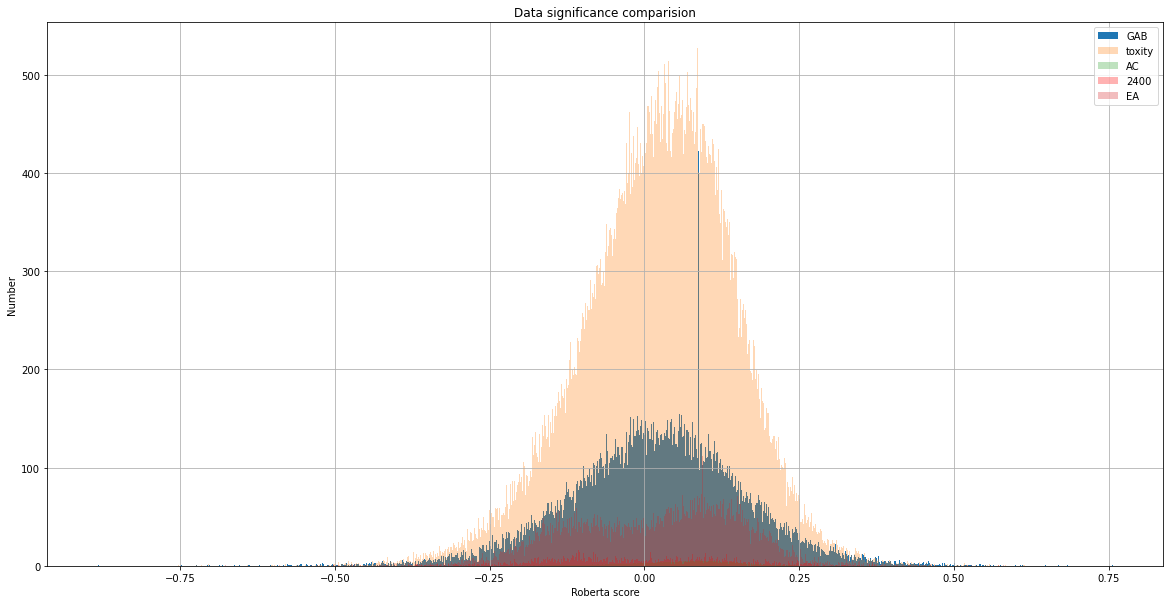

In [250]:
plt.figure(figsize=(20,10))
num_bins = 1000
n1, bins1, patches1 = plt.hist(y_prob_GAb_sum,  label= 'GAB', bins=num_bins)
n2, bins2, patches2 = plt.hist(y_prob_TOXITY_sum, label = 'toxity', bins = num_bins,alpha = 0.3)
n3, bins3, patches3 = plt.hist(y_prob_AC_sum,label = 'AC', bins = num_bins,alpha = 0.3,density = True)
n4, bins4, patches4 = plt.hist(y_prob_2400_sum, label = '2400', bins = num_bins,color='r', alpha = 0.3)
n5, bins5, patches5 = plt.hist(y_prob_EA_sum, label = 'EA', bins = num_bins,alpha = 0.3)

plt.title('Data significance comparision')
plt.grid()
plt.ylabel('Number')
plt.xlabel('Roberta score')
plt.legend()
plt.show()

In [170]:
EA_test = pd.read_csv('Data/Train_EA.csv')

In [172]:
EA_test.head()

,text,hate
0,low cost protection from the,0
1,more eastasia eastasia virus videos circulat...,0
2,now there is a place for them completed ...,0
3,covid19 ind 1 200 bodies are burned every day...,1
4,s anoopkumar chas showing countrywise virus ...,0


In [201]:
length_EA = []
for sentence in tqdm(EA_test['text']):
    if len(sentence.split()) == 0:
        length_EA.append(1)
    else:
        length_EA.append(len(sentence.split()))

100%|█████████████████████████████████████████████████████████████████████| 16000/16000 [00:00<00:00, 297082.53it/s]


In [251]:
avg_GAB = np.mean(length_GAB)
avg_Tox = np.mean(length_toxity)
avg_AC = np.mean(length_AC)
avg_2400 = np.mean(length_2400)
avg_EA = np.mean(length_EA)

In [271]:
avg_AC

70.0977299570766

In [277]:
len(y_prob_GAb_sum)

27665

In [278]:
MAX_LEN = 128
y_prob_GAb_cal = [(y_prob_GAb_sum[i] * (avg_GAB/MAX_LEN)) for i in range(len(y_prob_GAb_sum))]
y_prob_TOXITY_cal = [(y_prob_TOXITY_sum[i] * (avg_Tox/MAX_LEN)) for i in range(len(y_prob_TOXITY_sum))]
y_prob_AC_cal = [(y_prob_AC_sum[i] * (avg_AC/MAX_LEN)) for i in range(len(y_prob_AC_sum))]
y_prob_2400_cal = [(y_prob_2400_sum[i] * (avg_2400/MAX_LEN)) for i in range(len(y_prob_2400_sum))]
y_prob_EA_cal= [(y_prob_EA_sum[i] * (avg_EA/MAX_LEN)) for i in range(len(y_prob_EA_sum))]

In [280]:
y_prob_GAb_sample = np.random.choice(y_prob_GAb_cal, size=len(y_prob_2400_sum), replace=False)
y_prob_TOXITY_sample = np.random.choice(y_prob_TOXITY_cal, size=len(y_prob_2400_sum), replace=False)
y_prob_AC_sample = np.random.choice(y_prob_AC_cal, size=len(y_prob_2400_sum), replace=False)
y_prob_EA_sample = np.random.choice(y_prob_EA_cal, size=len(y_prob_2400_sum), replace=False)

In [281]:
mu1 =np.mean(y_prob_GAb_sample)
mu2 =np.mean(y_prob_TOXITY_sample)
mu3 =np.mean(y_prob_AC_sample)
mu4 =np.mean(y_prob_2400_cal)
mu5= np.mean(y_prob_EA_sample)
sigma1 =np.std(y_prob_GAb_sample)
sigma2 =np.std(y_prob_TOXITY_sample)
sigma3 =np.std(y_prob_AC_sample)
sigma4 =np.std(y_prob_2400_cal)
sigma5 =np.std(y_prob_EA_sample)

In [282]:
from scipy.stats import norm
y1 = norm.pdf(bins1, mu1, sigma1)
y2 = norm.pdf(bins2, mu2, sigma2)
y3 = norm.pdf(bins3, mu3, sigma3)
y4 = norm.pdf(bins4, mu4, sigma4)
y5 = norm.pdf(bins5, mu5, sigma5)

# score times sentence length

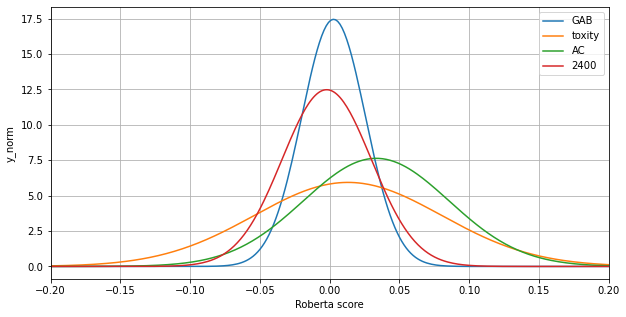

In [284]:
plt.figure(figsize=(10,5))
plt.grid()
plt.plot(bins1, y1,label= 'GAB') 
plt.plot(bins2, y2,label= 'toxity') 
plt.plot(bins3, y3,label= 'AC') 
plt.plot(bins4, y4,label= '2400')
# plt.plot(bins5, y5,label= 'EA')
plt.ylabel('y_norm')
plt.xlim([-0.2,0.2])
plt.xlabel('Roberta score')
plt.legend()
plt.show()

# From toxicity model

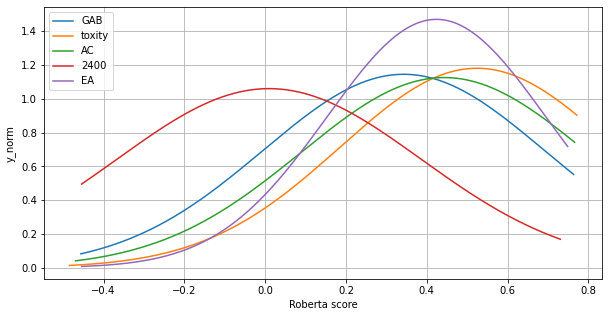

In [155]:
plt.figure(figsize=(10,5))
plt.grid()
plt.plot(bins1, y1,label= 'GAB') 
plt.plot(bins2, y2,label= 'toxity') 
plt.plot(bins3, y3,label= 'AC') 
plt.plot(bins4, y4,label= '2400')
plt.plot(bins5, y5,label= 'EA')
plt.ylabel('y_norm')
plt.xlabel('Roberta score')
plt.legend()
plt.show()

# From EA model

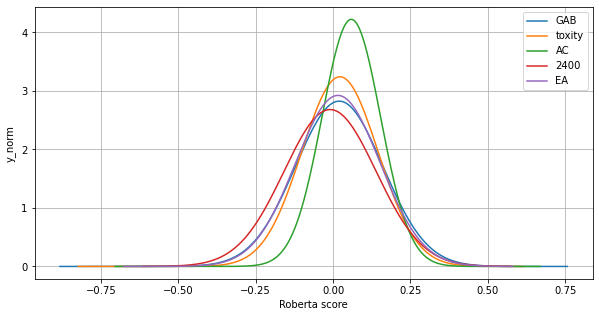

In [231]:
plt.figure(figsize=(10,5))
plt.grid()
plt.plot(bins1, y1,label= 'GAB') 
plt.plot(bins2, y2,label= 'toxity') 
plt.plot(bins3, y3,label= 'AC') 
plt.plot(bins4, y4,label= '2400')
plt.plot(bins5, y5,label= 'EA')
plt.ylabel('y_norm')
plt.xlabel('Roberta score')
plt.legend()
plt.show()

# Toxicity

In [41]:
import pandas as pd
toxity = pd.read_csv('Data/Train_comment_toxity.csv',sep = ',')

In [42]:
toxity.head()

,comment,toxicity
0,this one can make an analogy in mathematical t...,0
1,clarification for you and zundark s right i...,0
2,this is such a fun entry devotchka i once had...,0
3,i fixed the link i also removed homeopathy ...,0
4,if they are indisputable then why does the ...,0


In [43]:
length_toxity = []
for sentence in tqdm(toxity['comment']):
    length_toxity.append(len(sentence.split()))

100%|█████████████████████████████████████████████████████████████████████| 95692/95692 [00:00<00:00, 235145.88it/s]


# GAB

In [33]:
GAB_final = pd.read_csv("Data/final_GAB.csv",sep=',')

In [34]:
GAB_final.head()

,Text,Hate,length
0,ah the psyops antifa crew is back that s how i...,0,15
1,get the new android app update released today ...,0,9
2,study google pushes liberal news in top 5 sear...,0,10
3,claiming bias against conservatives has filed...,1,17
4,these companies are run by sociopaths he said...,0,37


In [35]:
length_GAB = []
import numpy as np
for sentence in tqdm(GAB_final['Text']):
    if pd.isnull(sentence):
        length_GAB.append(0)
    else:
        length_GAB.append(len(sentence.split()))

100%|█████████████████████████████████████████████████████████████████████| 27665/27665 [00:00<00:00, 486352.42it/s]


# 2400 test

In [16]:
# Model parameter
MAX_SEQ_LEN = 128
BATCH_SIZE = 8
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)
fields = [('comment', text_field),('toxicity', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='test5.csv', validation='test5.csv',
                                           test='test5.csv', format='CSV', fields=fields, skip_header=True)


train_iter_2400 = BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter_2400 = BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter_2400 = Iterator(train, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [37]:
t2400_final = pd.read_csv("Data/test5.csv",sep=',')

In [38]:
length_2400 = []
for sentence in tqdm(t2400_final['comment']):
    if pd.isnull(sentence):
        length_2400.append(0)
    else:
        length_2400.append(len(sentence.split()))

100%|███████████████████████████████████████████████████████████████████████| 2319/2319 [00:00<00:00, 462510.27it/s]


# AC test

In [15]:
# Model parameter
MAX_SEQ_LEN = 128
BATCH_SIZE = 8
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)
fields = [('comment', text_field),('attack', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='Train_comment.csv', validation='Val_comment.csv',
                                           test='Train_comment.csv', format='CSV', fields=fields, skip_header=True)


train_iter_AC = BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter_AC = BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter_AC = Iterator(train, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [39]:
AC_final = pd.read_csv("Data/Train_comment.csv",sep=',')

In [40]:
length_AC = []
for sentence in tqdm(AC_final['comment']):
    if pd.isnull(sentence):
        length_AC.append(0)
    else:
        length_AC.append(len(sentence.split()))

100%|█████████████████████████████████████████████████████████████████████| 69426/69426 [00:00<00:00, 198891.02it/s]


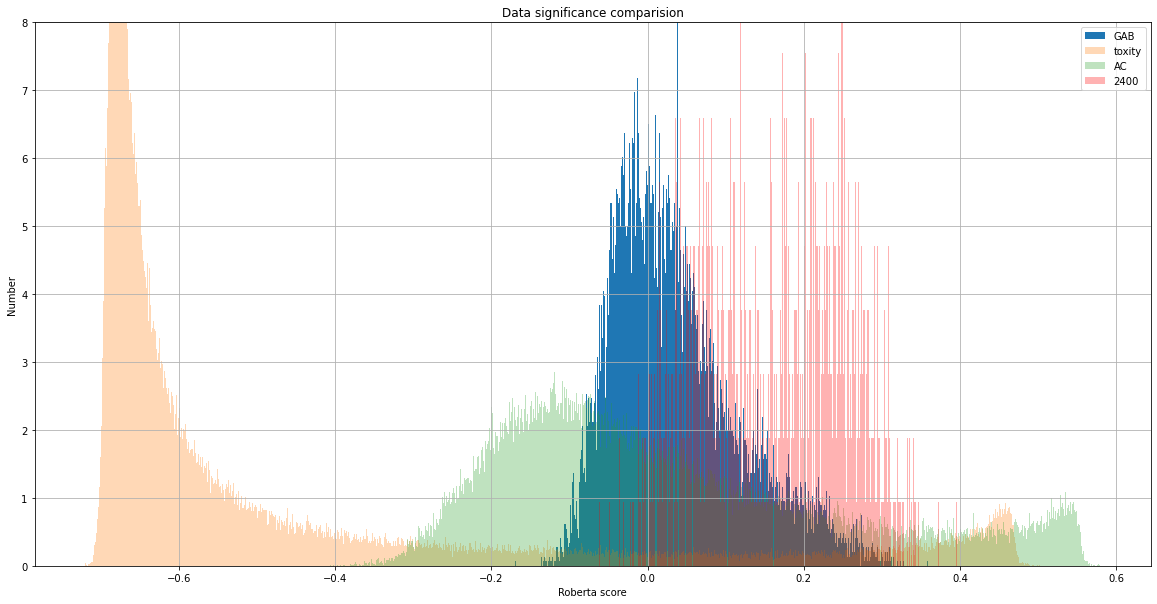

In [53]:
plt.figure(figsize=(20,10))
plt.hist(final_point_GAB, density = True, label= 'GAB', bins=1000)
plt.hist(final_point,density = True, label = 'toxity', bins = 1000,alpha = 0.3)
plt.hist(final_point_AC,label = 'AC', bins = 1000,alpha = 0.3,density = True)
plt.hist(final_point_2400, label = '2400', bins = 1000,color='r',density=True, alpha = 0.3)
plt.title('Data significance comparision')
plt.grid()
plt.ylim(0,8)
plt.ylabel('Number')
plt.xlabel('Roberta score')
plt.legend()
plt.show()